In [1]:
# General Imports
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

# Scripts 
folder_path = os.path.abspath("scripts")
sys.path.append(folder_path)

# Minkowski Functionals
from Minkowski_Fractal_Dimension import standard_minkowski_functionals

# Box Counting 
from Box_Counting_Fractal_Dimension import box_counting

# GRF
from GRF import generate_gaussian_random_field, estimate_correlation_length

# 2D Gaussian
from Gaussian import generate_2d_gaussian

# Sierpinski Triangle
from Sierpinski_Triangle import generate_sierpinski_triangle

# Visualization Tools
from visualization_tools import show_shapes_results, plot_GRF

# Image Analysis Specific Imports
from skimage.measure import perimeter,euler_number

[10:35:18] ERROR    PARDISO solver not installed, run `pip install pypardiso`. Otherwise,          ]8;id=550756;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py\_workspace.py]8;;\:]8;id=988574;file://c:\Users\User\anaconda3\envs\Astronomy_Env\Lib\site-packages\openpnm\utils\_workspace.py#56\56]8;;\
                    simulations will be slow. Apple M chips not supported.                                         

## 📌**Simulations with Simple Geometrical/Topological Features**

### **1: Line**

A line should return a (fractal) dimension of **D = 1**. Using the Box-Counting Method, we do indeed obtain this result. However, the Perimeter-Area (PA) relation presents a different picture. This discrepancy arises due to the inherent anti-correlation in the PA formula:

$$ A \propto k \cdot P^{2/D} $$

For a line:
- **Area:** $ A = 1 \cdot l $
- **Perimeter:** $ P = l $
- **Proportionality factor:** $ k = 1 $

Substituting these values:

$$ l \propto l^{2/D} $$

Solving for $ D $, we find that the PA method returns **D = 2**, highlighting the built-in anti-correlation of the formula.


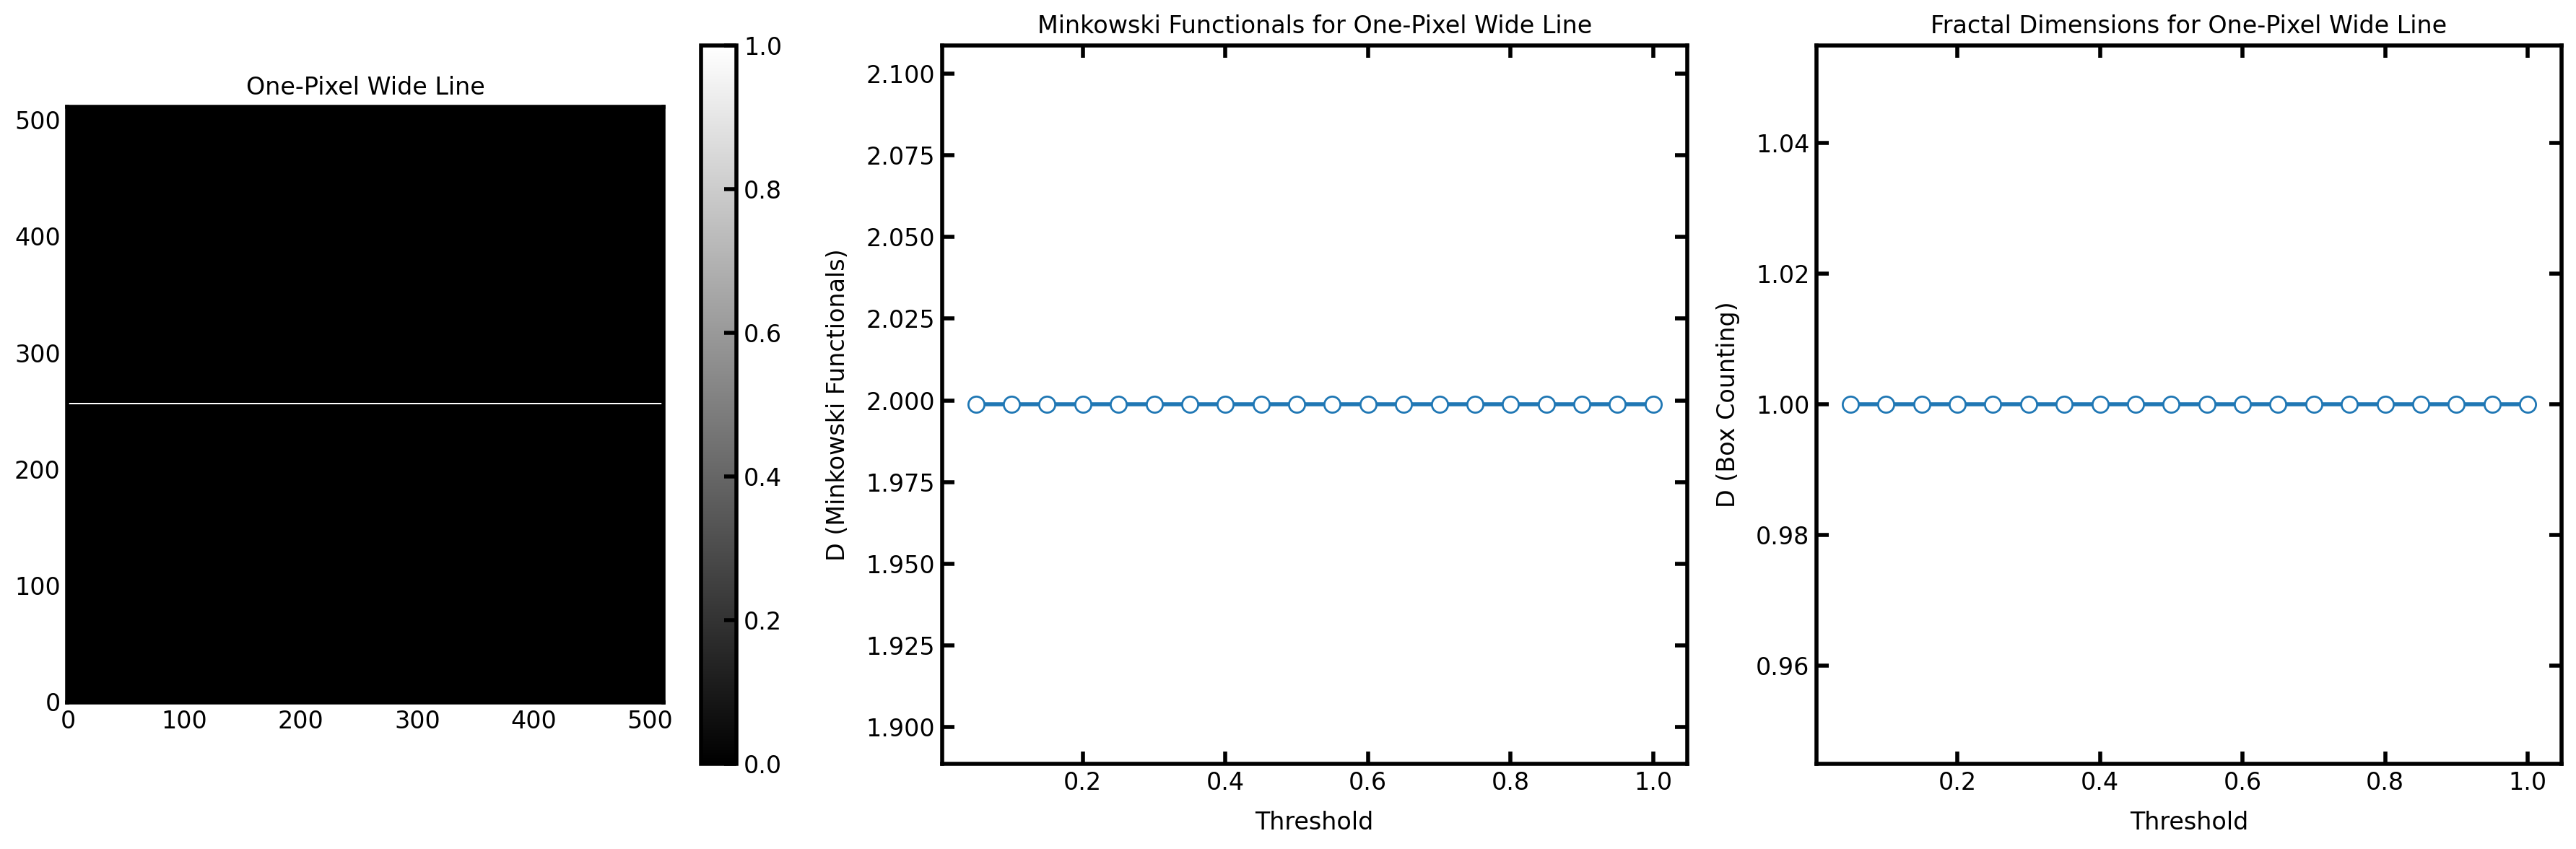

In [4]:
# Create a binary image with a one-pixel wide line
shape = (512, 512)
line_image = np.zeros(shape, dtype=bool)
line_image[shape[0] // 2, :] = 1  # Horizontal line in the middle

# Calculate Minkowski functionals for the line image
line_thresholds = np.linspace(0.05, 1, 20)
results = standard_minkowski_functionals(line_image.astype(float), thresholds=line_thresholds)

line_fractal_dimension_BC = []
for threshold in line_thresholds:
    line_fractal_dimension_BC.append(box_counting(line_image >= threshold))

show_shapes_results(line_image, "One-Pixel Wide Line", line_thresholds, results, line_fractal_dimension_BC)

### **2: A Filled Plane**

For a plane, we expect a (fractal) dimension of **D = 2** with the Box-Counting Method and **D = 1** with the Perimeter-Area (PA) Method. The Box-Counting Method confirms this expectation, but the PA result appears slightly off.

This discrepancy arises because the formula:

$$ A = l^2 $$
$$ P = 4 \cdot l $$

Substituting these values:

$$ l^2 \propto l^{2/D} $$

hence **D = 2** in the PA relation. When substituted into the PA formula, this leads to an unexpected result of around 1.22. However, when using the corrected implementation in `plane_corrected_minkowski_functionals`, which includes the proportionality factor $k$, we obtain exactly the expected values: **D = 2** for the Box-Counting Method and **D = 1** for the PA Method.

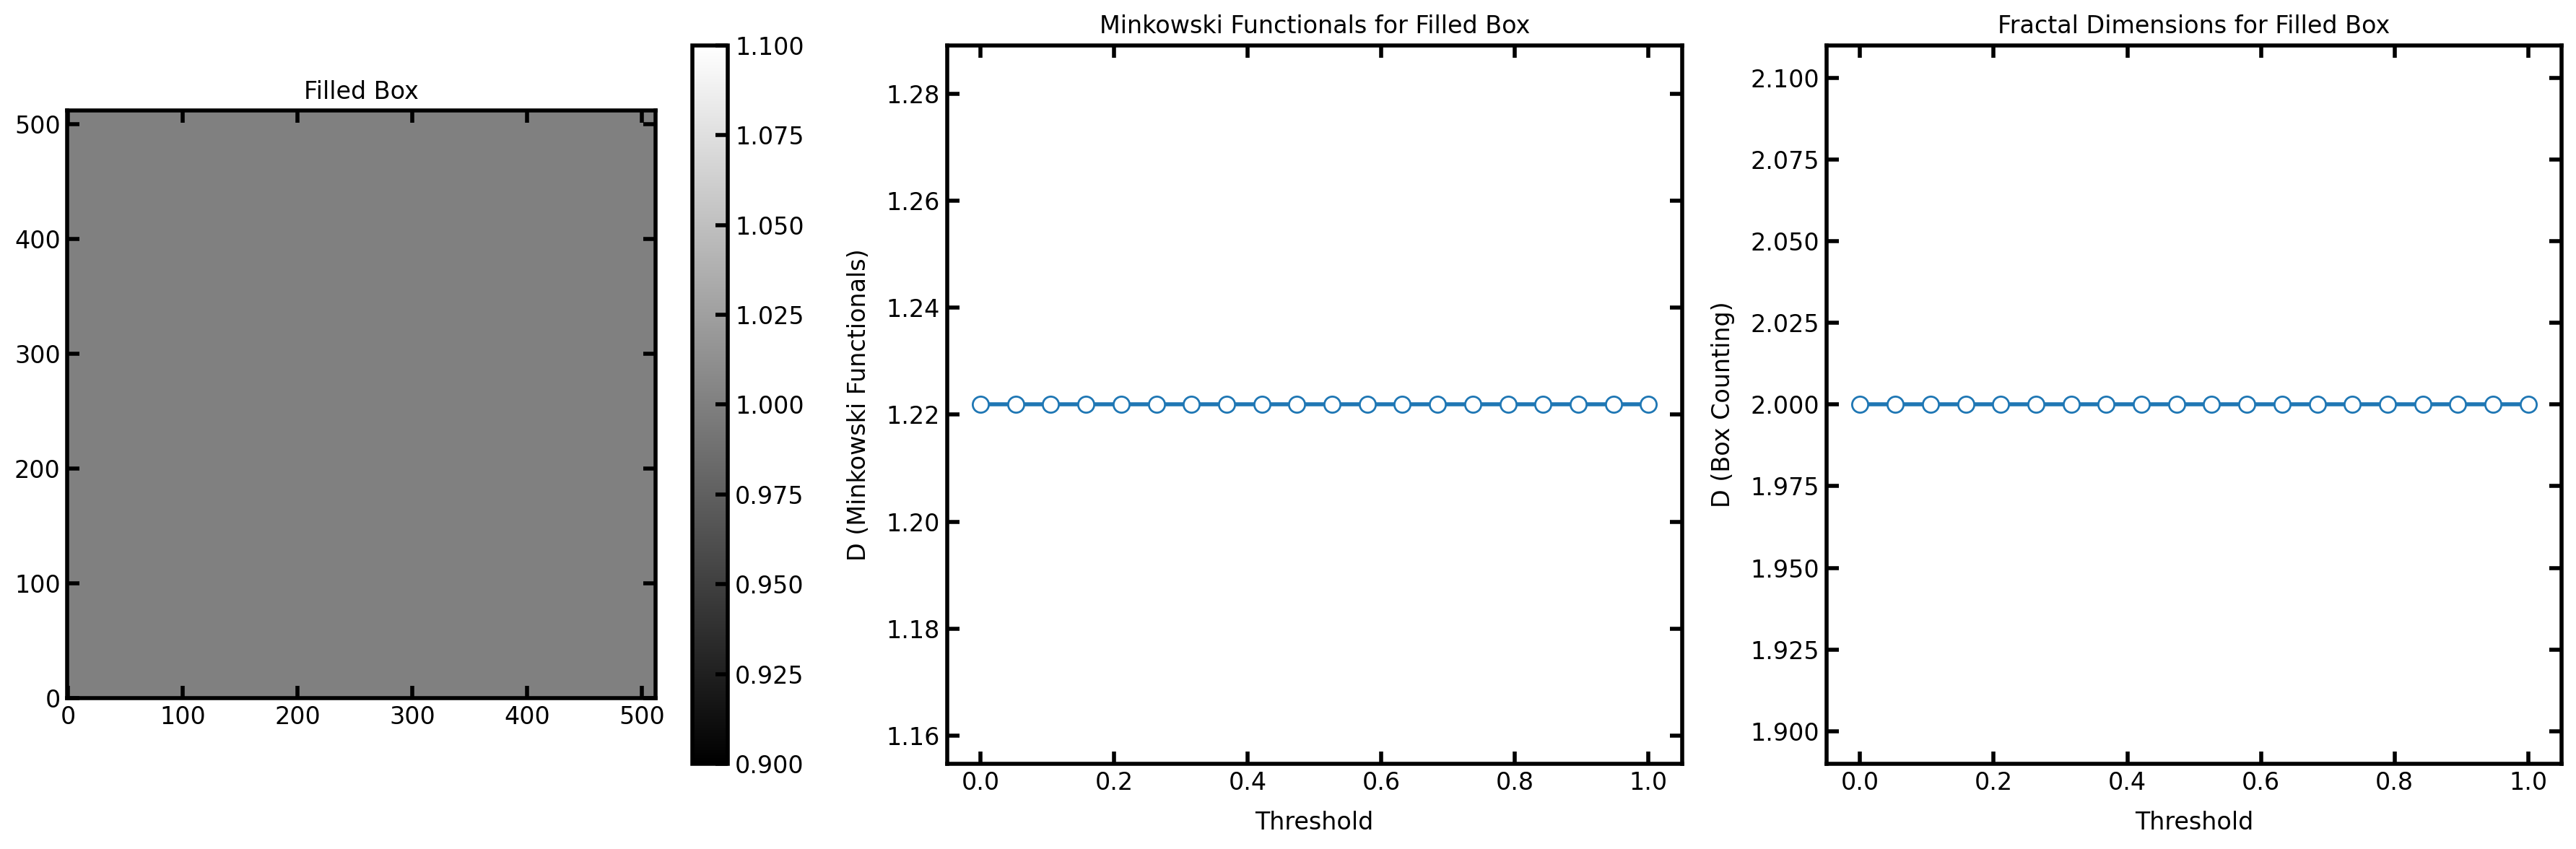

In [4]:
# not corrected version
# Create a binary image with a filled box
shape = (512, 512)
box_image = np.ones(shape, dtype=bool)

# Calculate Minkowski functionals for the box image
box_thresholds = np.linspace(0, 1, 20)
box_results = standard_minkowski_functionals(box_image.astype(float), thresholds=box_thresholds)

# Calculate fractal dimensions using box counting method
box_fractal_dimension_BC = []
for threshold in box_thresholds:
    box_fractal_dimension_BC.append(box_counting(box_image >= threshold))

show_shapes_results(box_image, "Filled Box", box_thresholds, box_results, box_fractal_dimension_BC)

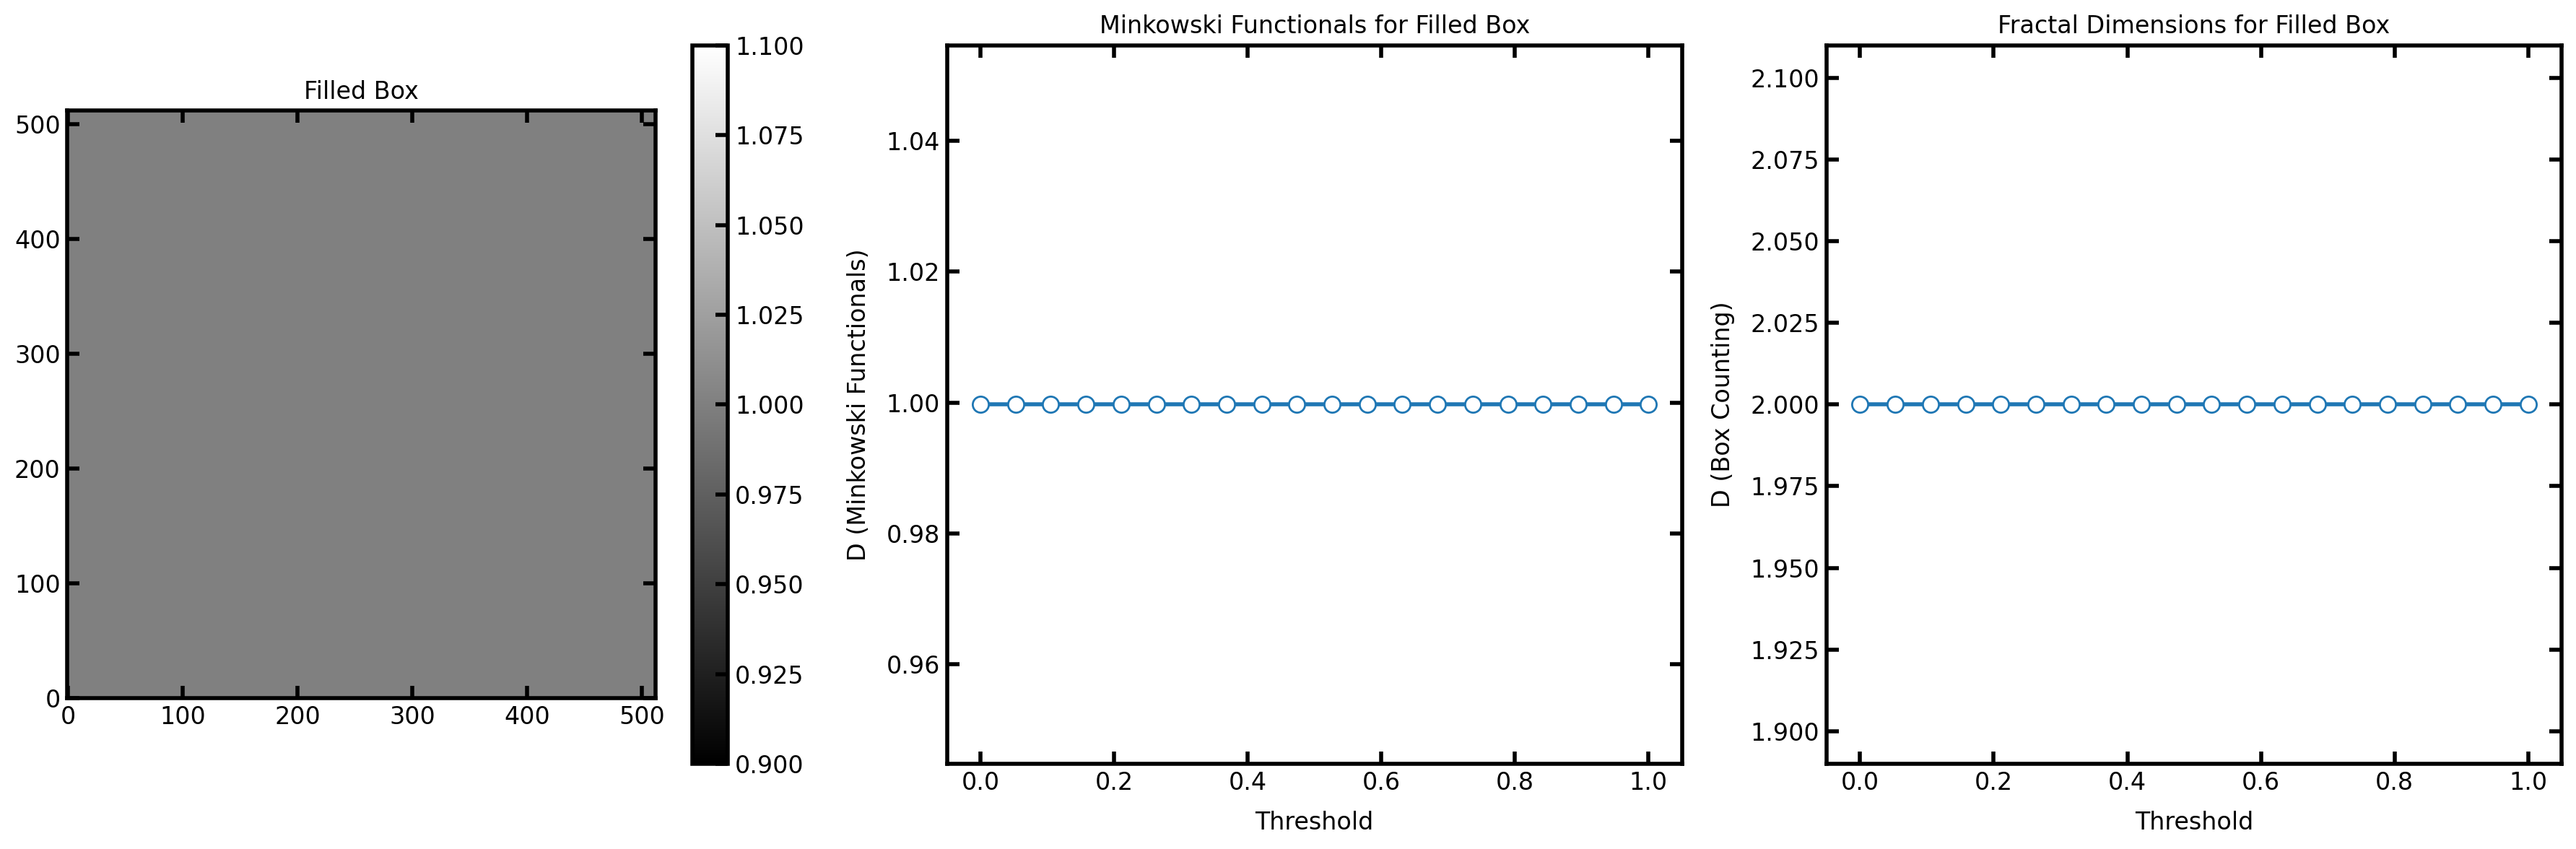

In [5]:
# correction for plane
def plane_corrected_minkowski_functionals(data, threshold_min = 1e20, threshold_max=1e22, thresholds = None):

    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1) with correction for the plane dimension
        perim = perimeter(mask)/4
        perimeters.append(perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)

    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)

    D = 2*log_perimeters/log_areas

    return {
        "thresholds": thresholds,
        "areas": areas,
        "perimeters": perimeters,
        "euler_chars": euler_chars,
        "fractal_dimension": D
    }

# Calculate Minkowski functionals (corrected) for the box image
box_thresholds = np.linspace(0, 1, 20)
box_results = plane_corrected_minkowski_functionals(box_image.astype(float), thresholds=box_thresholds)

# Calculate fractal dimensions using box counting method
box_fractal_dimension_BC = []
for threshold in box_thresholds:
    box_fractal_dimension_BC.append(box_counting(box_image >= threshold))

show_shapes_results(box_image, "Filled Box", box_thresholds, box_results, box_fractal_dimension_BC)

### **3: A Circle**

The expected (fractal) dimension of a filled circle should be **D = 2** in the Box-Counting Method and **D = 1** in the Perimeter-Area (PA) relation.

For a circle:
- **Area:** $$ A = \pi r^2 $$
- **Perimeter:** $$ P = 2 \pi r $$

From which it follows that the dimension from the PA relation should be 1. This is achieved again with the correction involving the proportionality factor.

Also important: In the Box-Counting Method, we observe a dependence on the object's scale, returning different results if the circle is smaller or bigger. The Perimeter-Area method, however, is not affected by this.

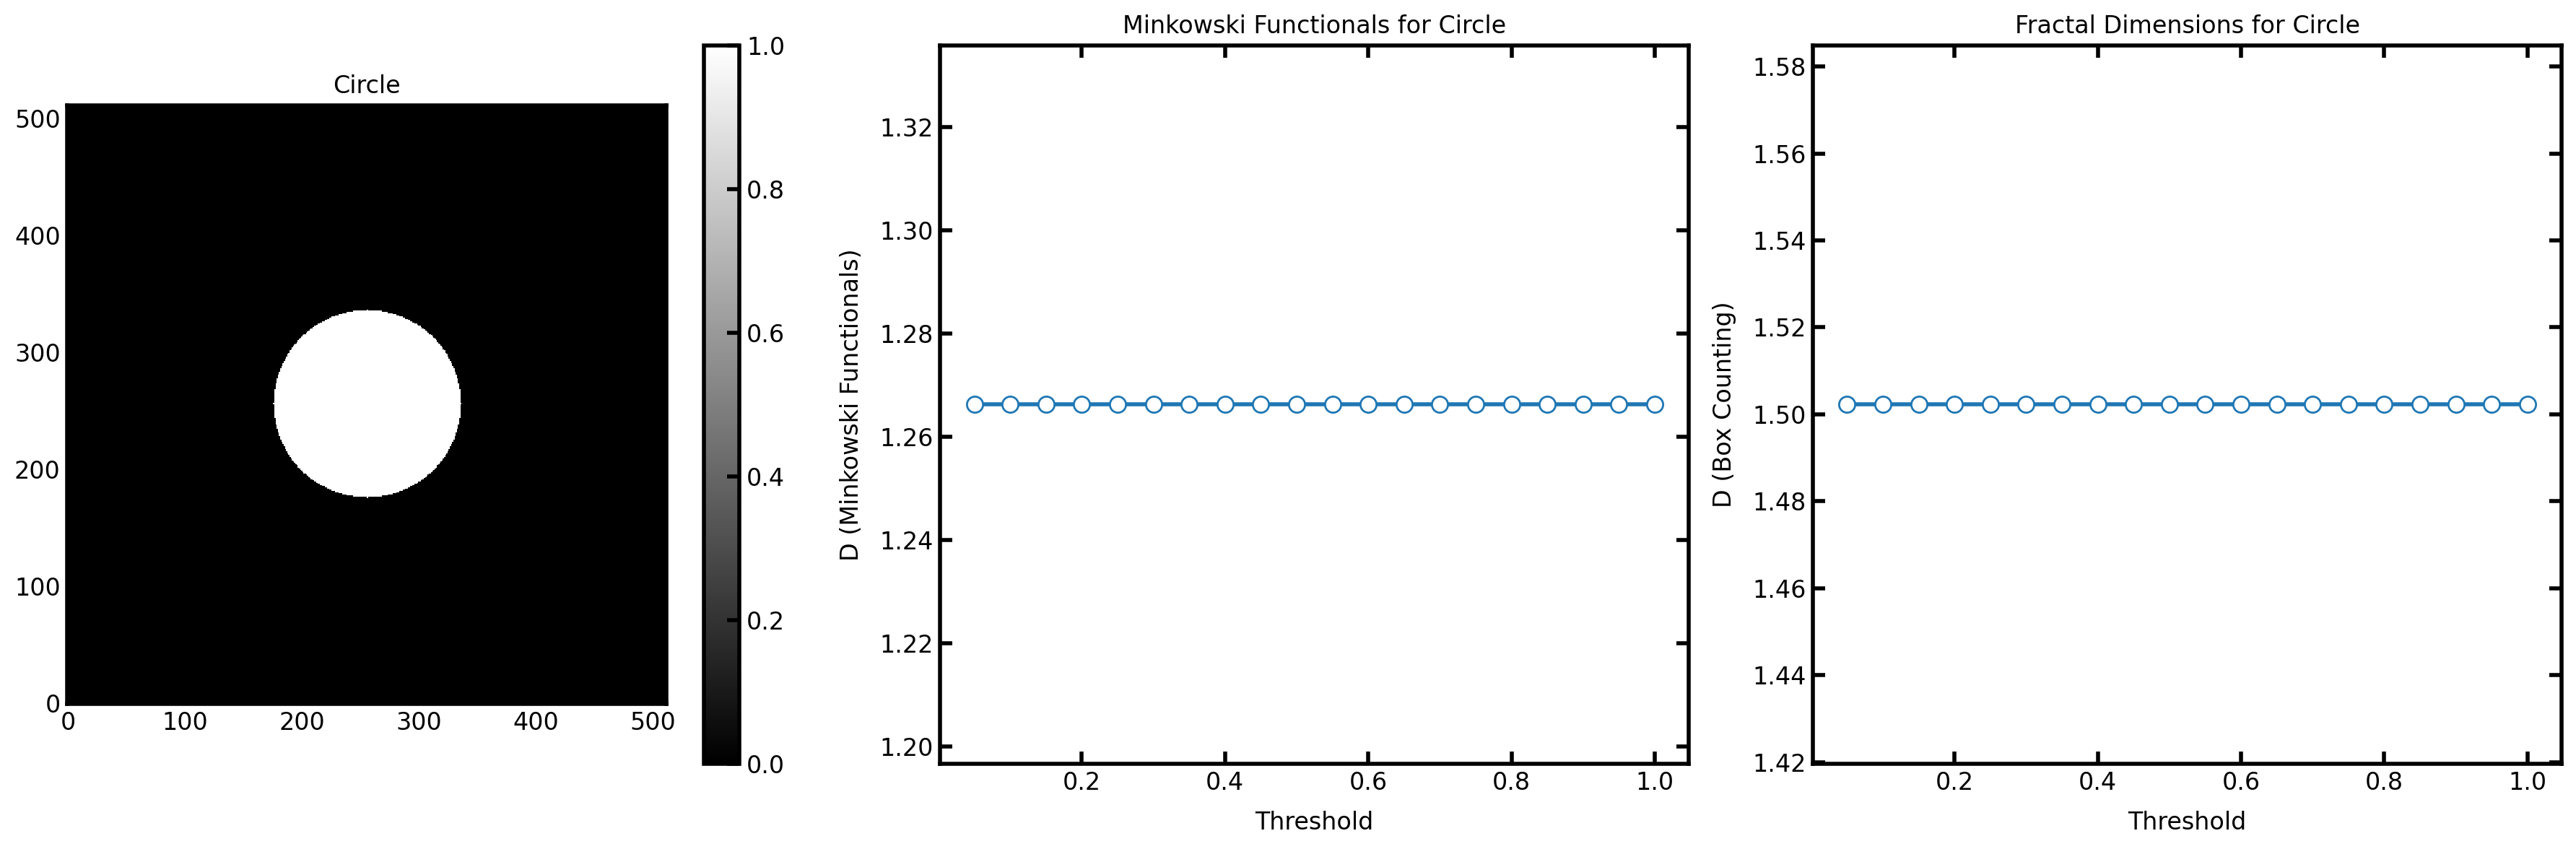

In [5]:
# Standard (not corrected)
# Create a binary image with a circle
circle_image = np.zeros(shape, dtype=bool)
rr, cc = np.ogrid[:shape[0], :shape[1]]
circle_center = (shape[0] // 2, shape[1] // 2)
circle_radius = 80
circle_image[(rr - circle_center[0])**2 + (cc - circle_center[1])**2 <= circle_radius**2] = 1

# Calculate Minkowski functionals for the circle image
circle_thresholds = np.linspace(0.05, 1, 20)
circle_results = standard_minkowski_functionals(circle_image.astype(float), thresholds=circle_thresholds)

# Calculate fractal dimensions using box counting method
circle_fractal_dimension_BC = []
for threshold in circle_thresholds:
    circle_fractal_dimension_BC.append(box_counting(circle_image >= threshold))

show_shapes_results(circle_image, "Circle", circle_thresholds, circle_results, circle_fractal_dimension_BC)

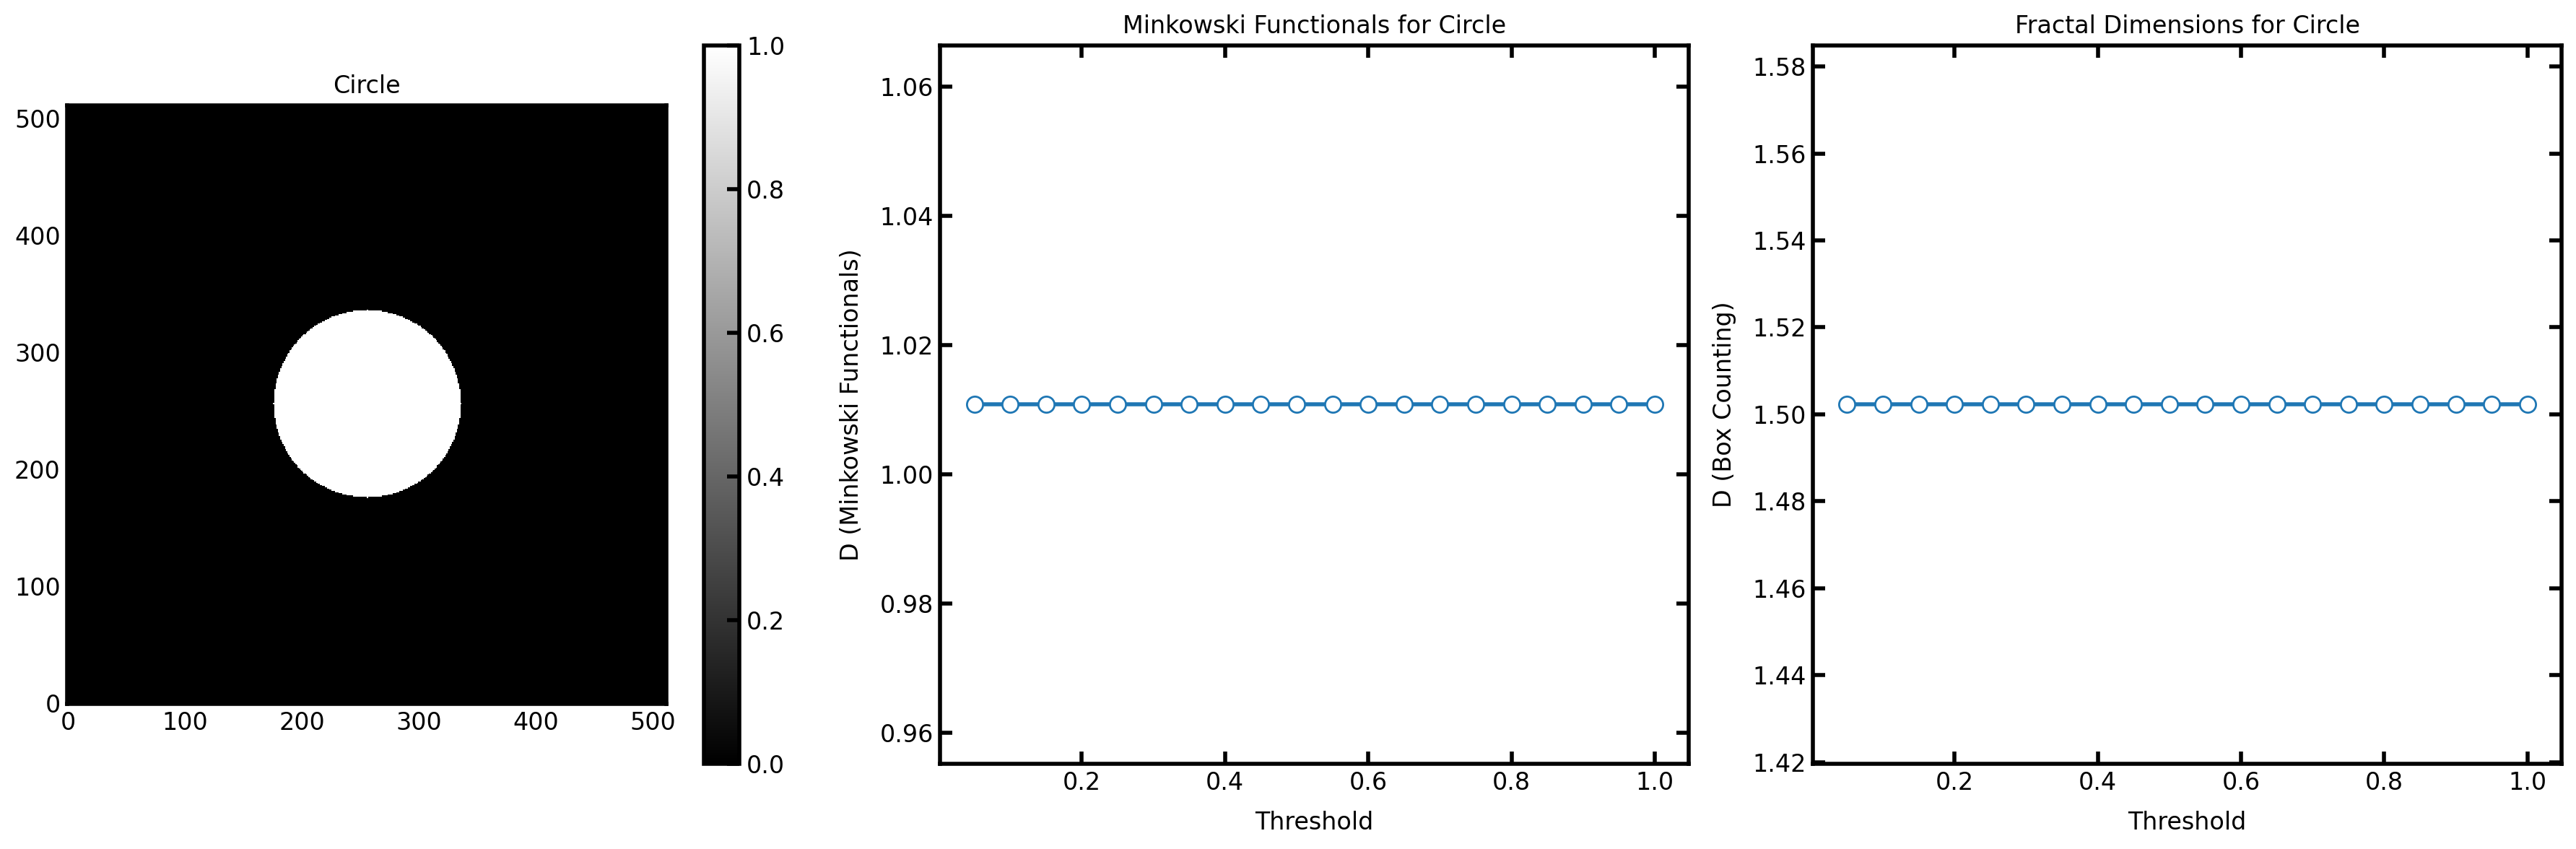

In [ ]:
# Intercept corrected circle
def circle_corrected_minkowski_functionals(data, threshold_min = 1e20, threshold_max=1e22, thresholds = None):

    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1)
        perim = perimeter(mask)
        perimeters.append(perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)

    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)

    D = 2*(log_perimeters - np.log10(2*np.sqrt(np.pi)))/(log_areas)

    return {
        "thresholds": thresholds,
        "areas": areas,
        "perimeters": perimeters,
        "euler_chars": euler_chars,
        "fractal_dimension": D
    }

# Calculate Minkowski functionals for the circle image
circle_thresholds = np.linspace(0.05, 1, 20)
circle_results = circle_corrected_minkowski_functionals(circle_image.astype(float), thresholds=circle_thresholds)

# Calculate fractal dimensions using box counting method
circle_fractal_dimension_BC = []
for threshold in circle_thresholds:
    circle_fractal_dimension_BC.append(box_counting(circle_image >= threshold))

show_shapes_results(circle_image, "Circle", circle_thresholds, circle_results, circle_fractal_dimension_BC)

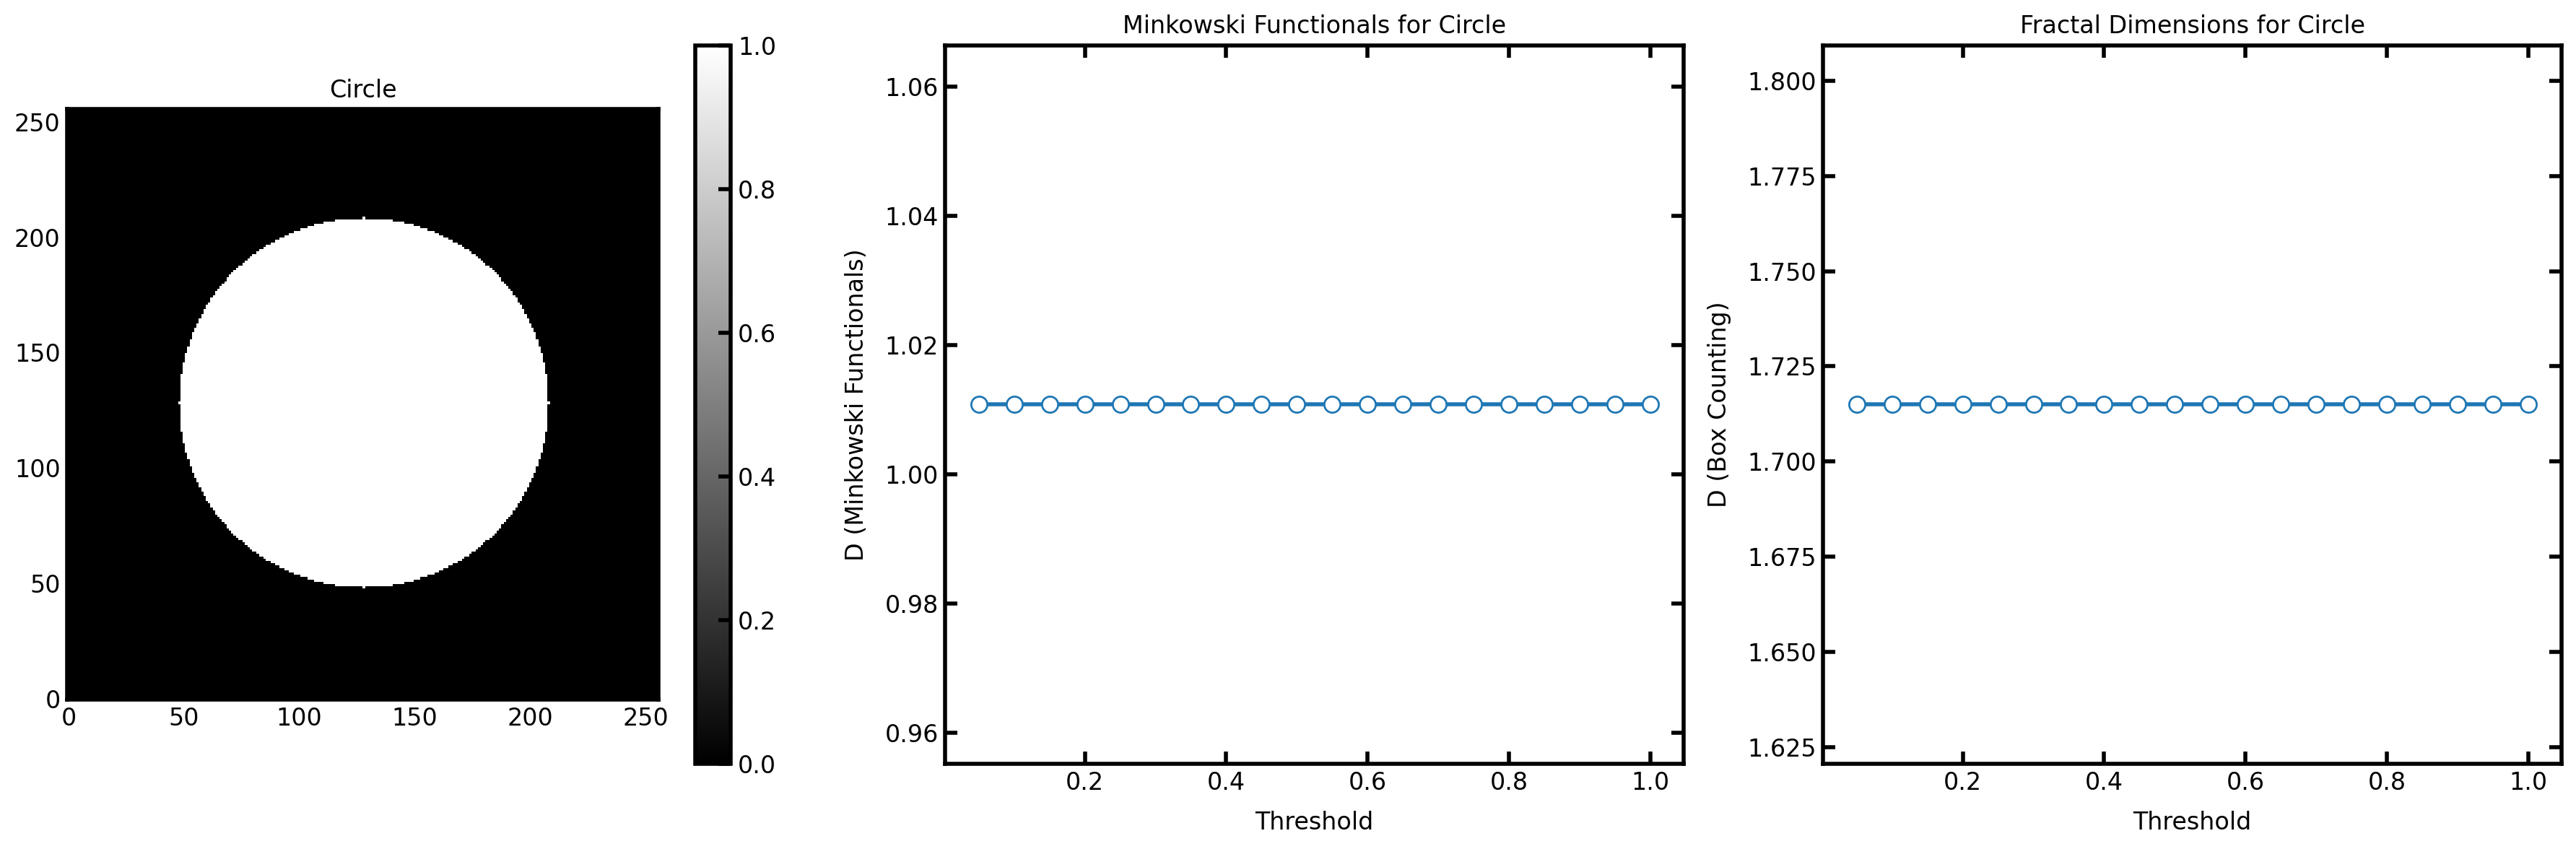

In [7]:
# Intercept corrected circle, but smaller to show that the BC method results in different values, whereas the Minkowski functionals are the same.
shape = (256, 256)

circle_image = np.zeros(shape, dtype=bool)
rr, cc = np.ogrid[:shape[0], :shape[1]]
circle_center = (shape[0] // 2, shape[1] // 2)
circle_radius = 80
circle_image[(rr - circle_center[0])**2 + (cc - circle_center[1])**2 <= circle_radius**2] = 1

# Calculate Minkowski functionals for the circle image
circle_thresholds = np.linspace(0.05, 1, 20)
circle_results = circle_corrected_minkowski_functionals(circle_image.astype(float), thresholds=circle_thresholds)

# Calculate fractal dimensions using box counting method
circle_fractal_dimension_BC = []
for threshold in circle_thresholds:
    circle_fractal_dimension_BC.append(box_counting(circle_image >= threshold))

show_shapes_results(circle_image, "Circle", circle_thresholds, circle_results, circle_fractal_dimension_BC)

### **4: An Actual Fractal: The Sierpinski Triangle**

This is one of the most stricking examples of the anti-correlation. Even in the case of an actual fractal, the two methods behave in opposite ways. But this is no simple shape like above, and a simple correction is hard to implement as the perimeter grows to infinity for each iteration.

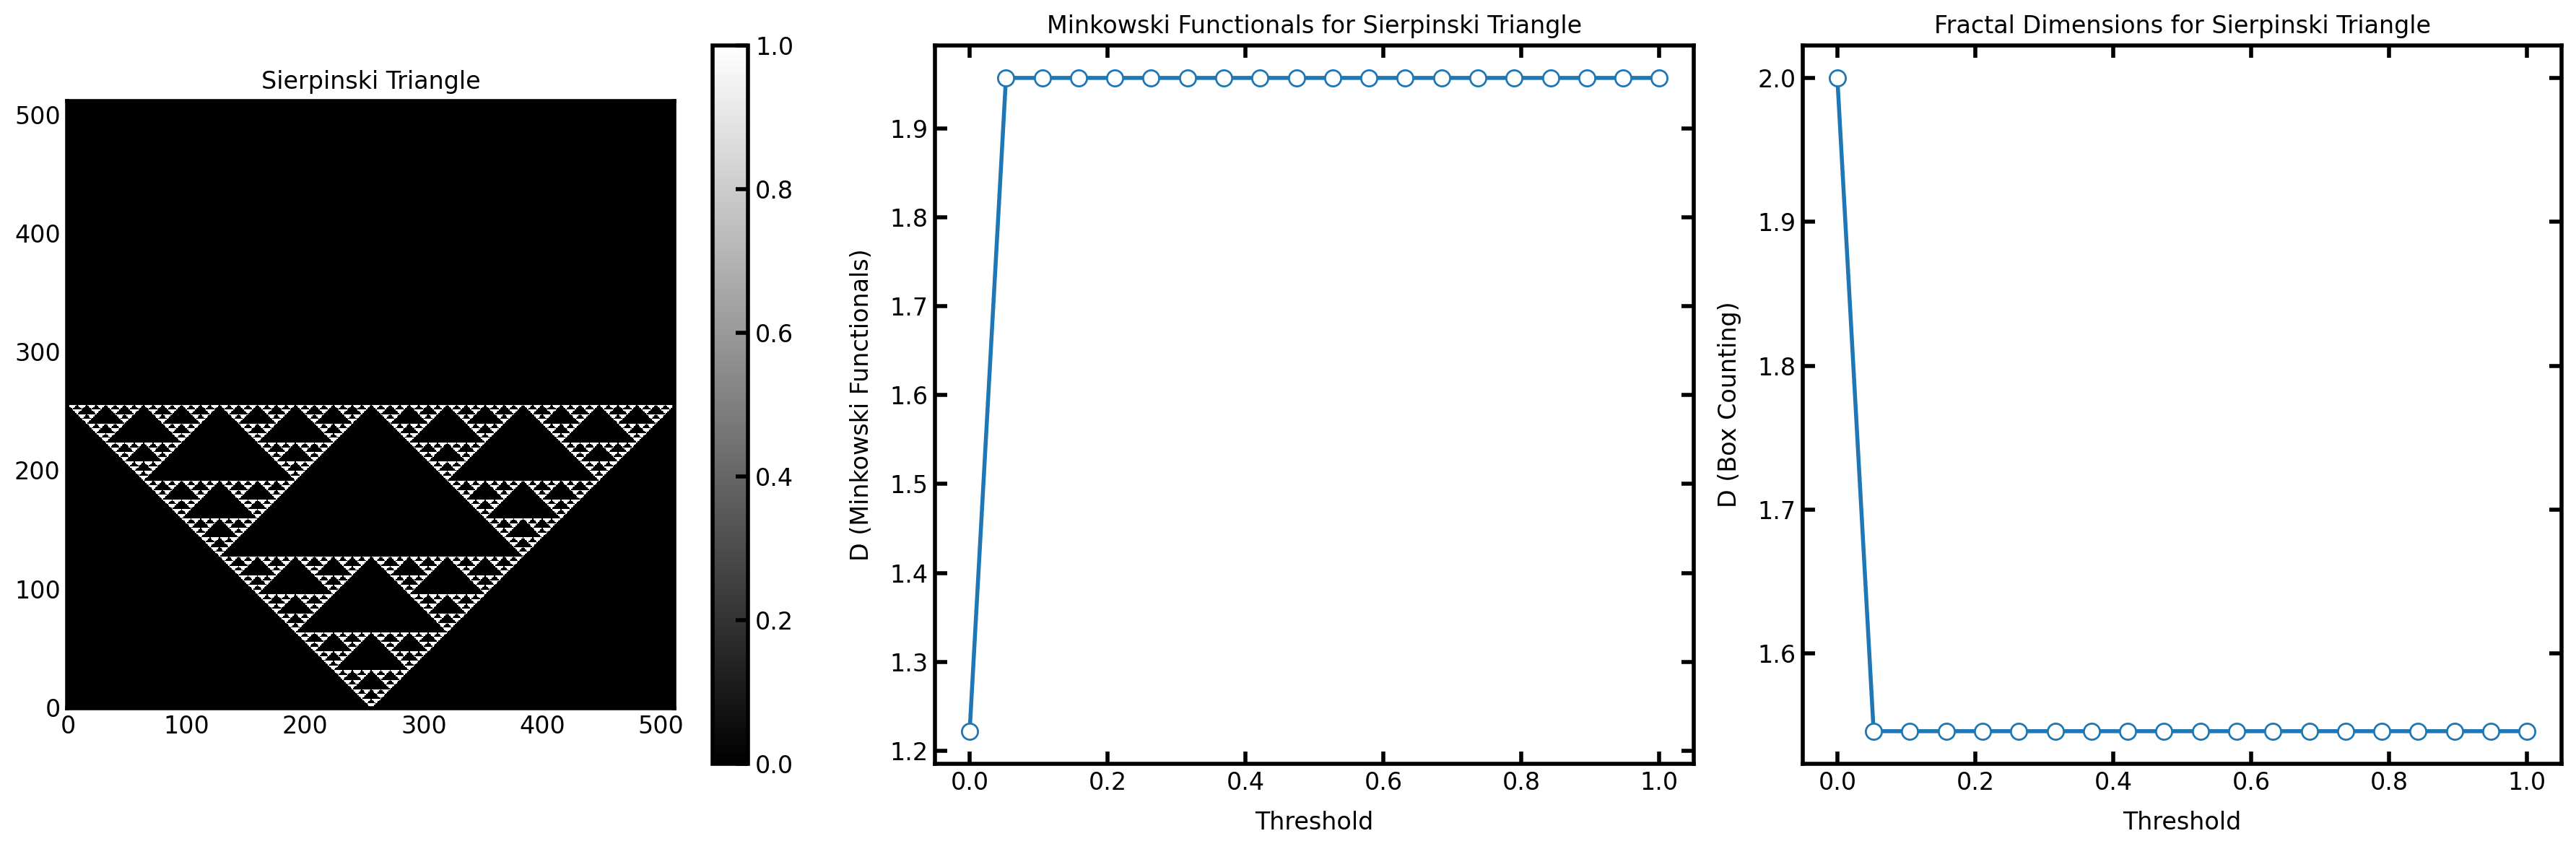

In [26]:
true_dimension = 1.58496
size = 512
iterations = 6
sierpinski_triangle = generate_sierpinski_triangle(size, iterations)

# Calculate Minkowski functionals for the Gaussian
sierpinski_thresholds = np.linspace(np.min(sierpinski_triangle), np.max(sierpinski_triangle), 20)
sierpinski_results = standard_minkowski_functionals(sierpinski_triangle, thresholds=sierpinski_thresholds)

# Calculate fractal dimensions using box counting method
sierpinski_thresholds_fractal_dimensions_BC = []
for threshold in sierpinski_thresholds:
    sierpinski_thresholds_fractal_dimensions_BC.append(box_counting(sierpinski_triangle >= threshold))

show_shapes_results(sierpinski_triangle, "Sierpinski Triangle", sierpinski_thresholds, sierpinski_results, sierpinski_thresholds_fractal_dimensions_BC)

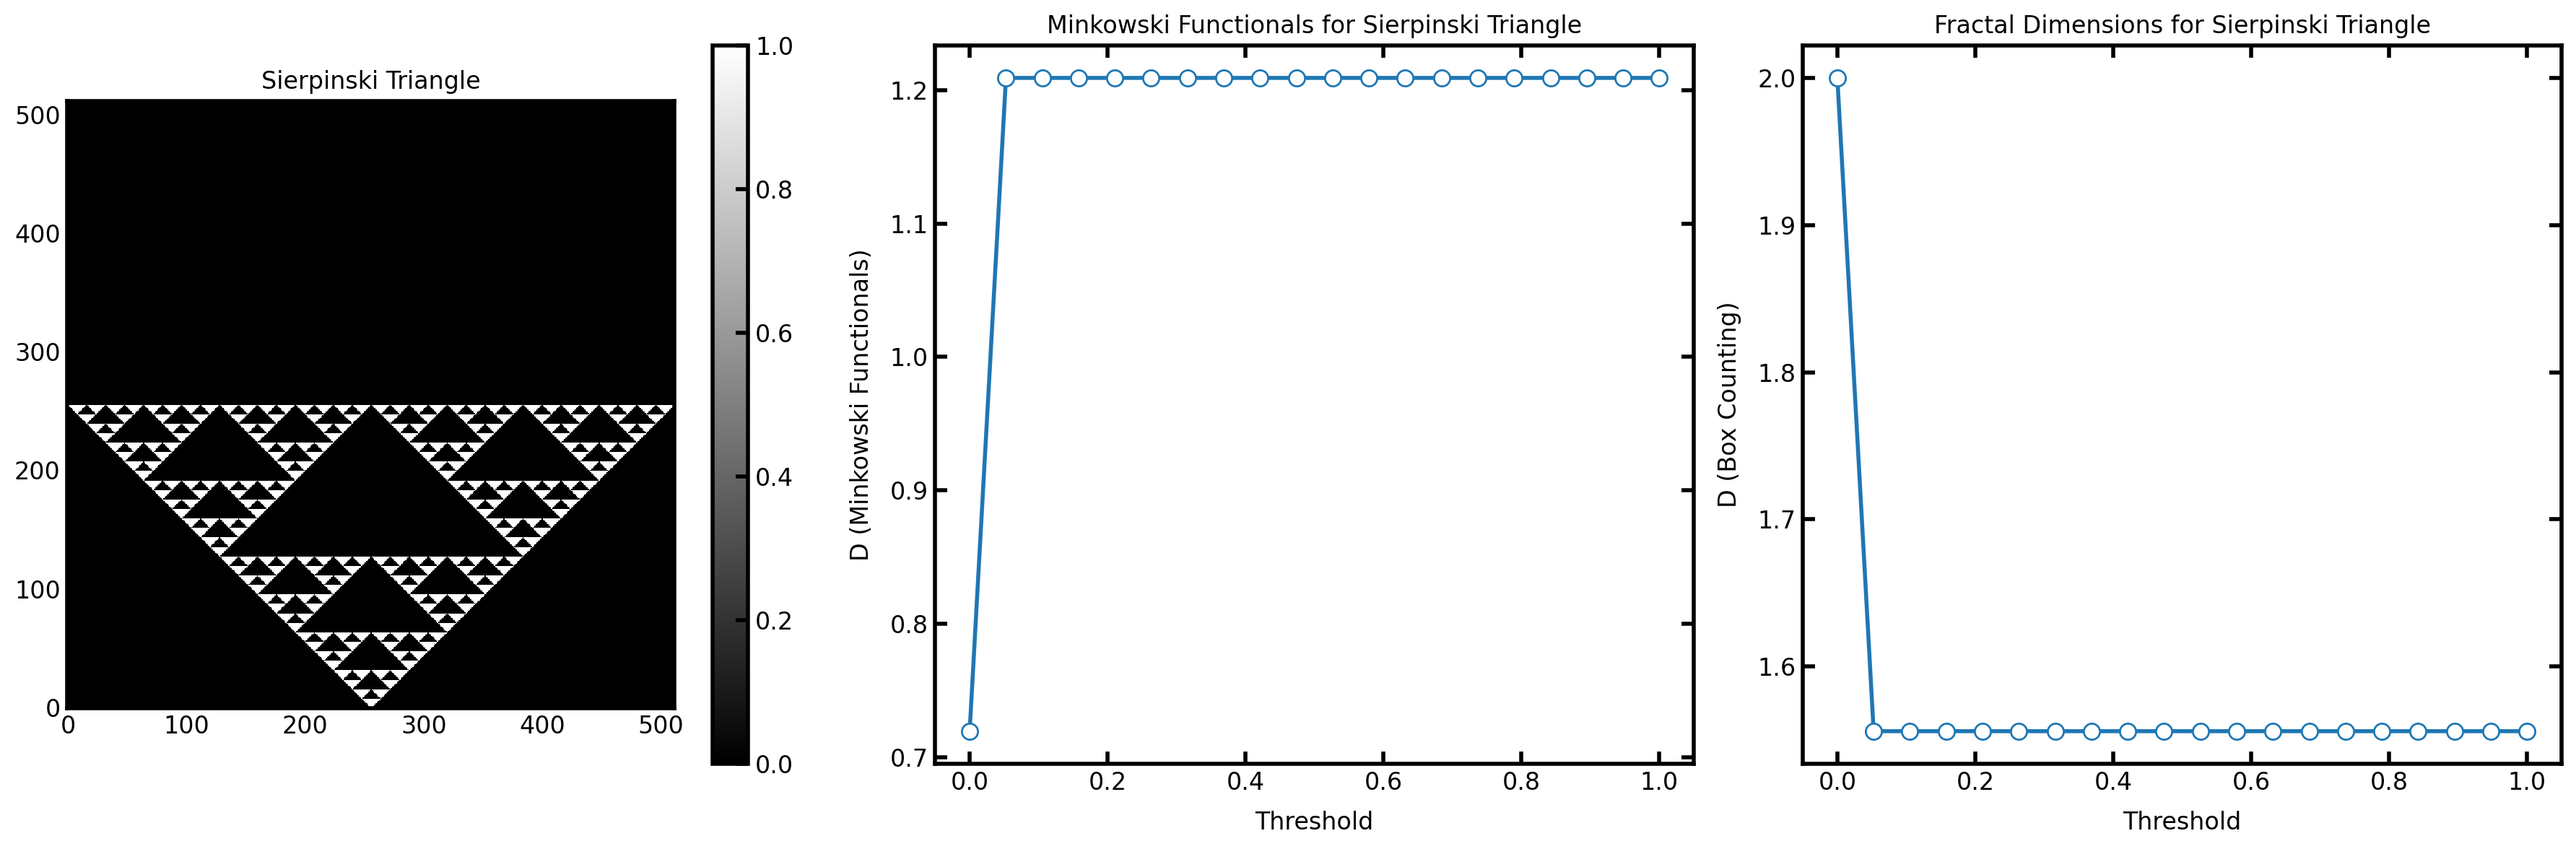

In [51]:
# Intercept corrected Sierpinski TRriangle
def sierpinski_corrected_minkowski_functionals(data, threshold_min = 1e20, threshold_max=1e22, thresholds = None):

    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1)
        perim = perimeter(mask)
        perimeters.append(perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)

    # Convert to log scale for fractal dimension analysis
    k = 5
    vorfaktor = (2**(k+1))*(3**(-(k+1)))*(1 - (3/4)**(k))*(np.sqrt(3)/4)

    log_areas = np.log10(np.array(areas))
    log_perimeters = np.log10(np.array(perimeters))

    D = 2*(log_perimeters - np.log10(1/vorfaktor))/(log_areas)

    return {
        "thresholds": thresholds,
        "areas": areas,
        "perimeters": perimeters,
        "euler_chars": euler_chars,
        "fractal_dimension": D
    }

true_dimension = 1.58496
size = 512
iterations = 5
sierpinski_triangle = generate_sierpinski_triangle(size, iterations)

# Calculate Minkowski functionals for the Gaussian
sierpinski_thresholds = np.linspace(np.min(sierpinski_triangle), np.max(sierpinski_triangle), 20)
sierpinski_results = sierpinski_corrected_minkowski_functionals(sierpinski_triangle, thresholds=sierpinski_thresholds)

# Calculate fractal dimensions using box counting method
sierpinski_thresholds_fractal_dimensions_BC = []
for threshold in sierpinski_thresholds:
    sierpinski_thresholds_fractal_dimensions_BC.append(box_counting(sierpinski_triangle >= threshold))

show_shapes_results(sierpinski_triangle, "Sierpinski Triangle", sierpinski_thresholds, sierpinski_results, sierpinski_thresholds_fractal_dimensions_BC)

### **Which formula is to be used then?**

The PA relation always shows an anti-correlation with the Box-Counting Method, yet both describe similar structural properties. The geometry of the object is also encoded in the proportionality constant $ k $. The next logical step was to determine a general formula incorporating $ k $ that could be applied universally. However, fitting for $ k $ consistently failed to return the expected values for known, simple structures. Only by providing an initial guess specifically tailored to each object was it possible to approximate the values derived earlier.

In practice, we want to avoid making geometric assumptions when analyzing clouds. Even though we now have a better understanding of potential values for $ k $ and their implications for the method, fitting for $ k $ would impose an unwanted bias. Therefore, I suggest that we should rely on the original formula:

$$ A \propto P^{2/D} $$

This ensures a more consistent analysis of structures without assuming anything about the shape. It is also the overall trend that we are interested in, as shown in the `Fractal_Dimension_PA.ipynb`.

More tests are run in `Simulations_PA.ipynb`. (WIP)

## **Further Tests**
### **5: GRF**

An interesting example arises when analyzing a Gaussian Random Field (GRF). While our real data is not Gaussian, the GRF provides a useful theoretical case for understanding the behavior of the different fractal dimension measures.  Instead of exhibiting a strict anticorrelation between the Minkowski Dimension and the Box Counting measure (as seen in the other examples), the GRF behaves differently. 

#### **Minkowski Dimension Analysis**

The overall shape of the PA curve is more symmetric, with a distinct maximum, which is indicative of a characteristic scale at which the structures in the GRF are most prominent.
In the PA method, we can also observe a breakdown at small scales, which suggests that the method is not working properly on really fine-sized structures.

#### **Box-Counting Method Analysis**

Interestingly, the Box-Counting method provides always the same result for the GRF. It always follows the same pattern, transitioning from a dimension of approximately 2 down to near 0. This is also for me a bit hard to interpret, as the fractal dimension should be between 1 and 2. 

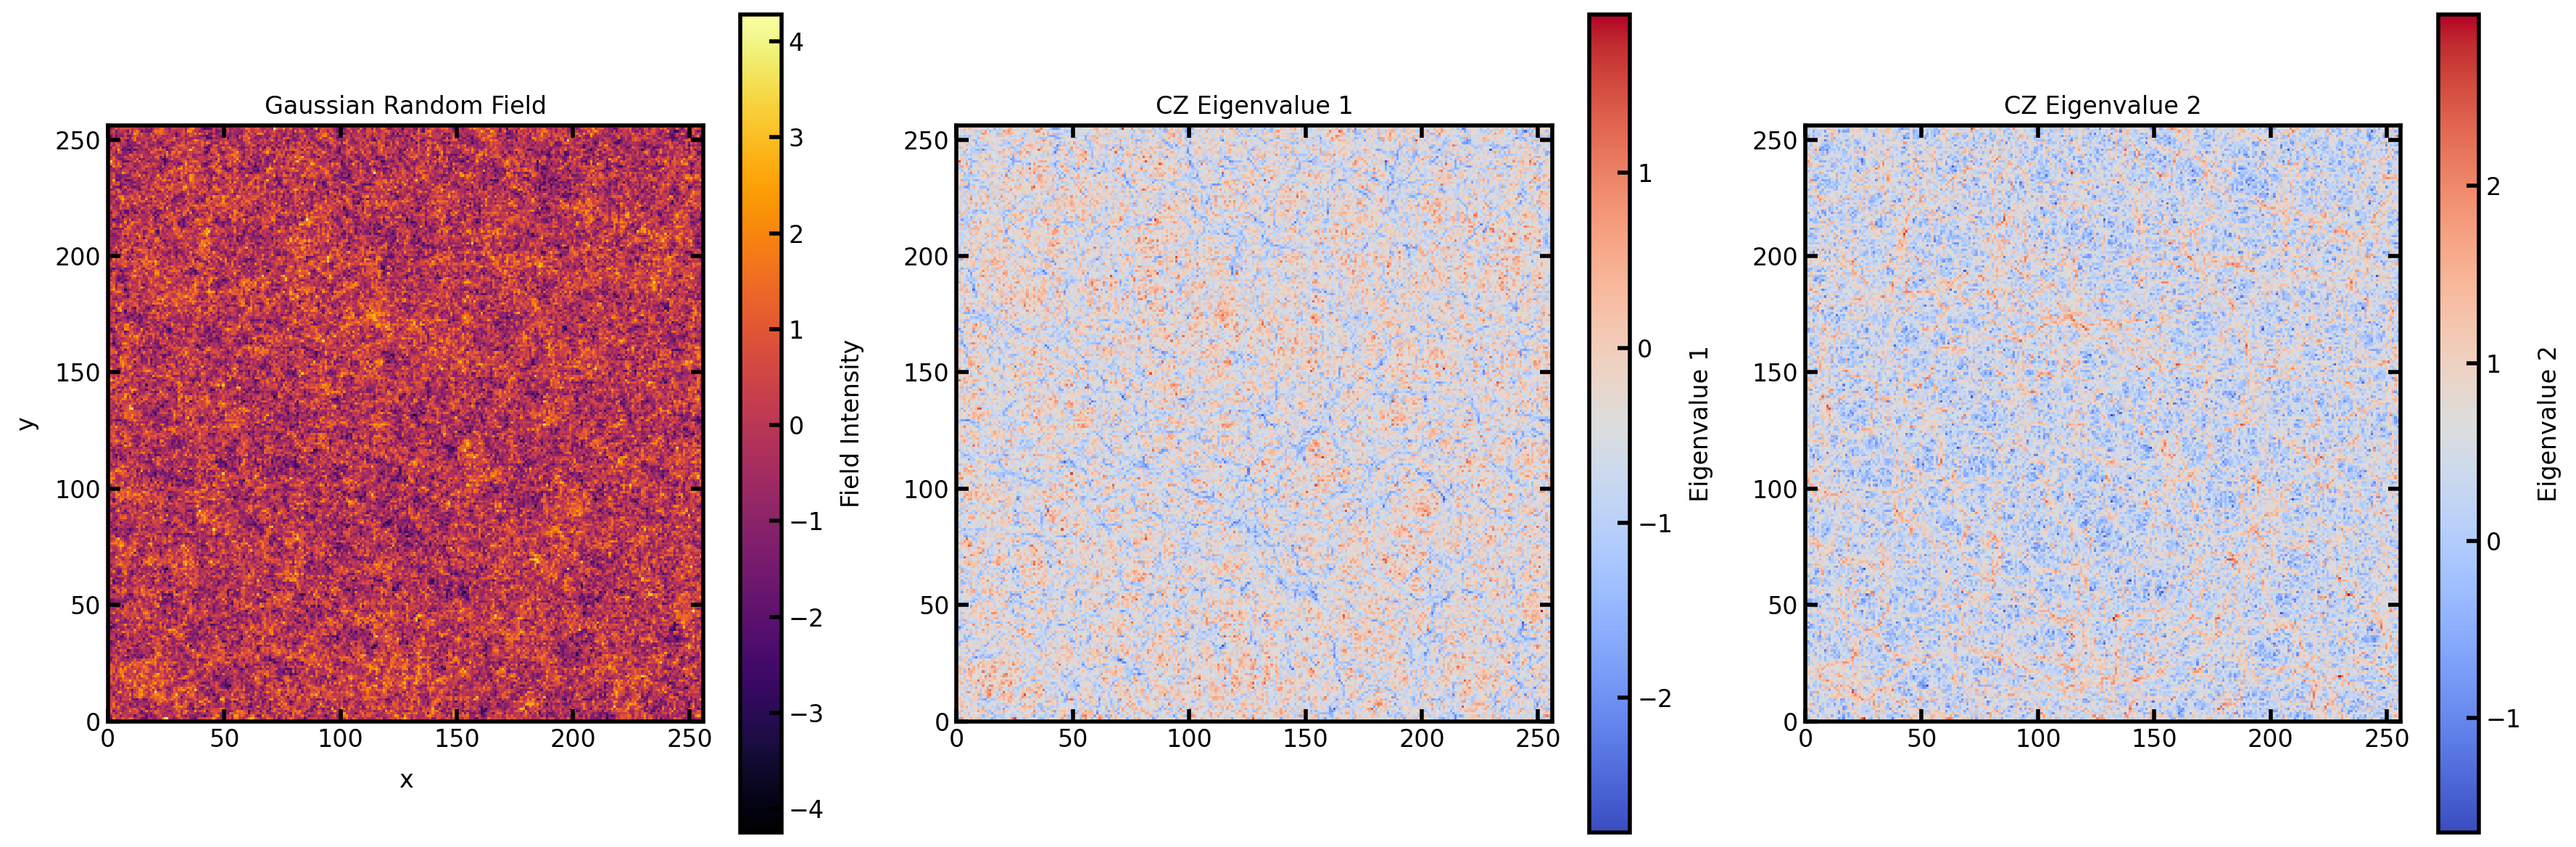

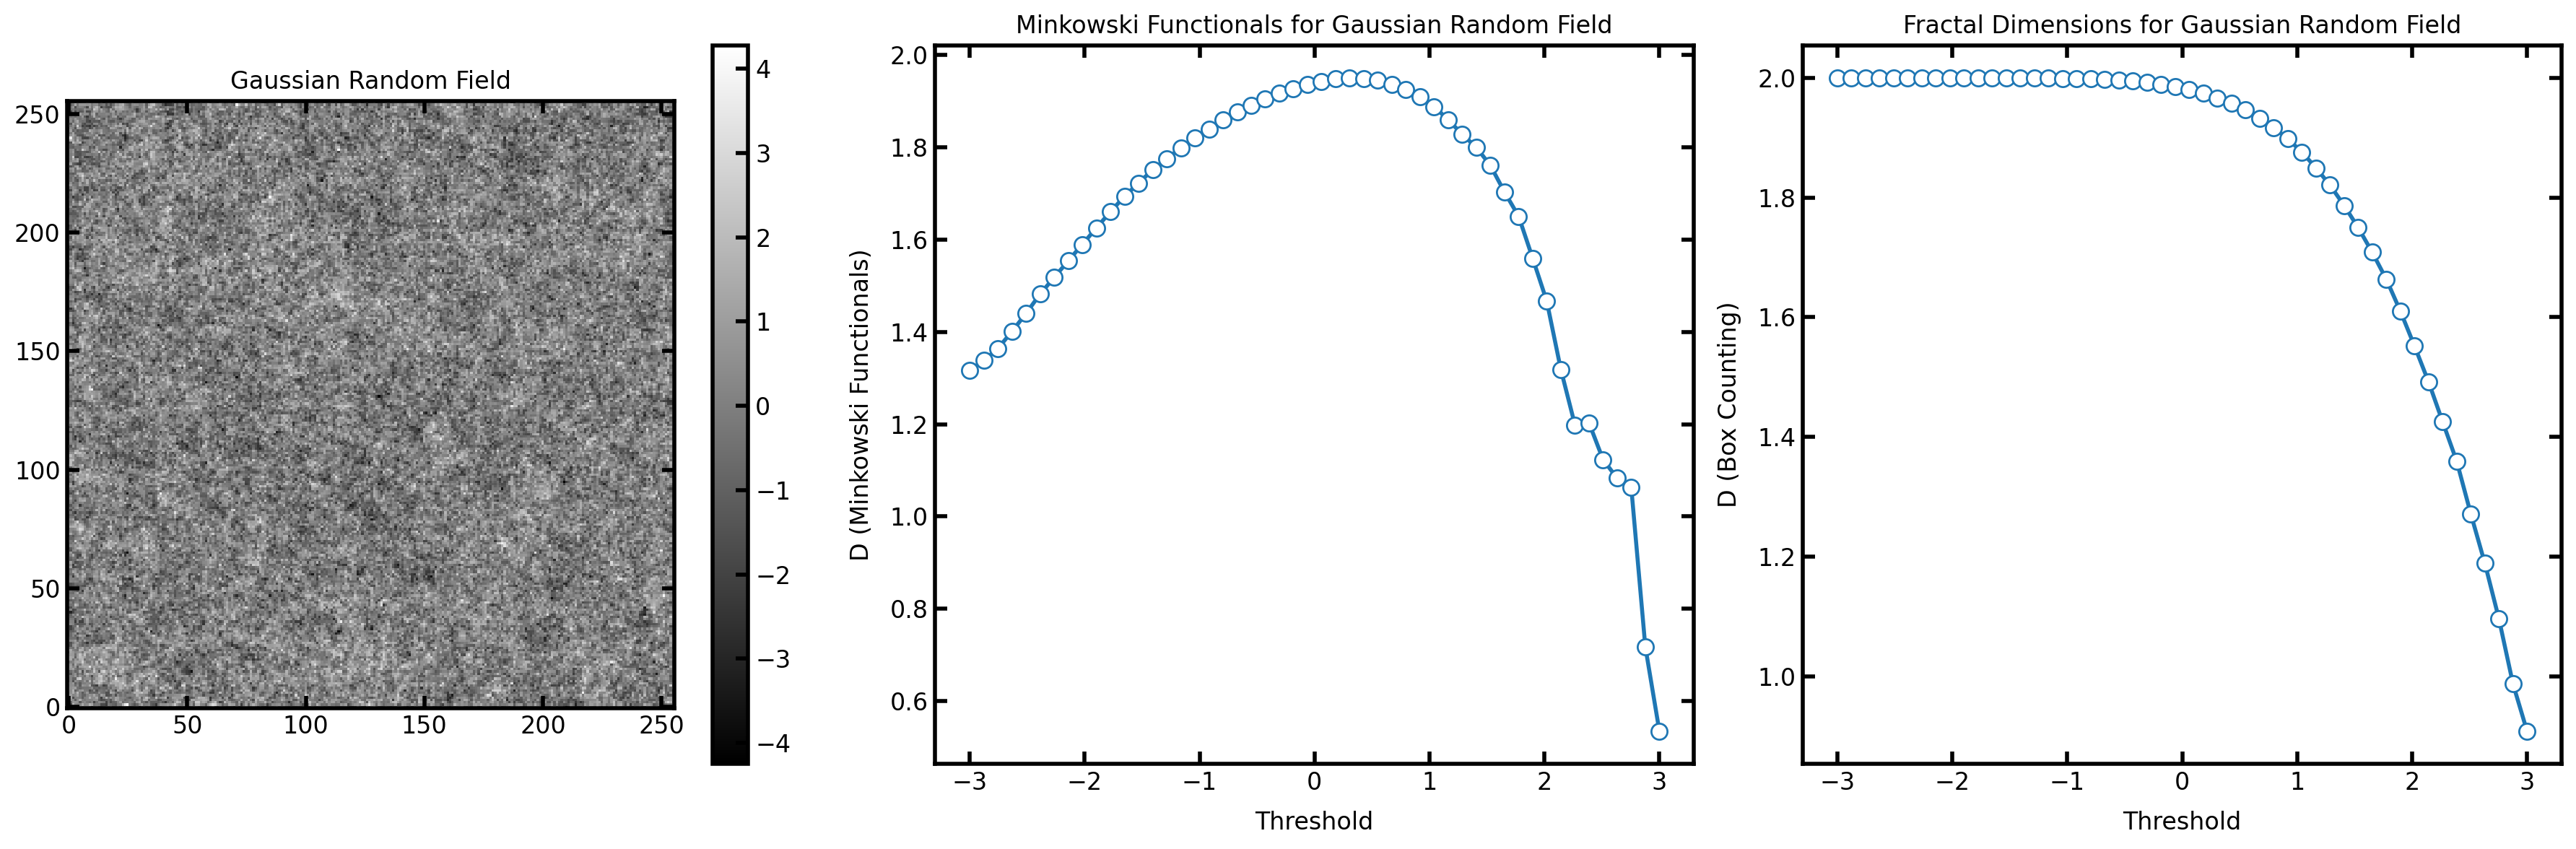

In [9]:
# Generate the Gaussian random field
size = 256   # Size of the grid (256x256)
a = -1.0     # Power spectrum exponent
field, field_CZ_eval = generate_gaussian_random_field(size, a)

plot_GRF(field, field_CZ_eval, size)

# Calculate Minkowski functionals for the circle image
GRF_thresholds = np.linspace(-3., 3., 50)
GRF_results = standard_minkowski_functionals(field.astype(float), thresholds=GRF_thresholds)

# Calculate fractal dimensions using box counting method
GRF_fractal_dimensions_BC = []
for threshold in GRF_thresholds:
    GRF_fractal_dimensions_BC.append(box_counting(field >= threshold))

show_shapes_results(field, "Gaussian Random Field", GRF_thresholds, GRF_results, GRF_fractal_dimensions_BC)
# print(estimate_correlation_length(field, size))

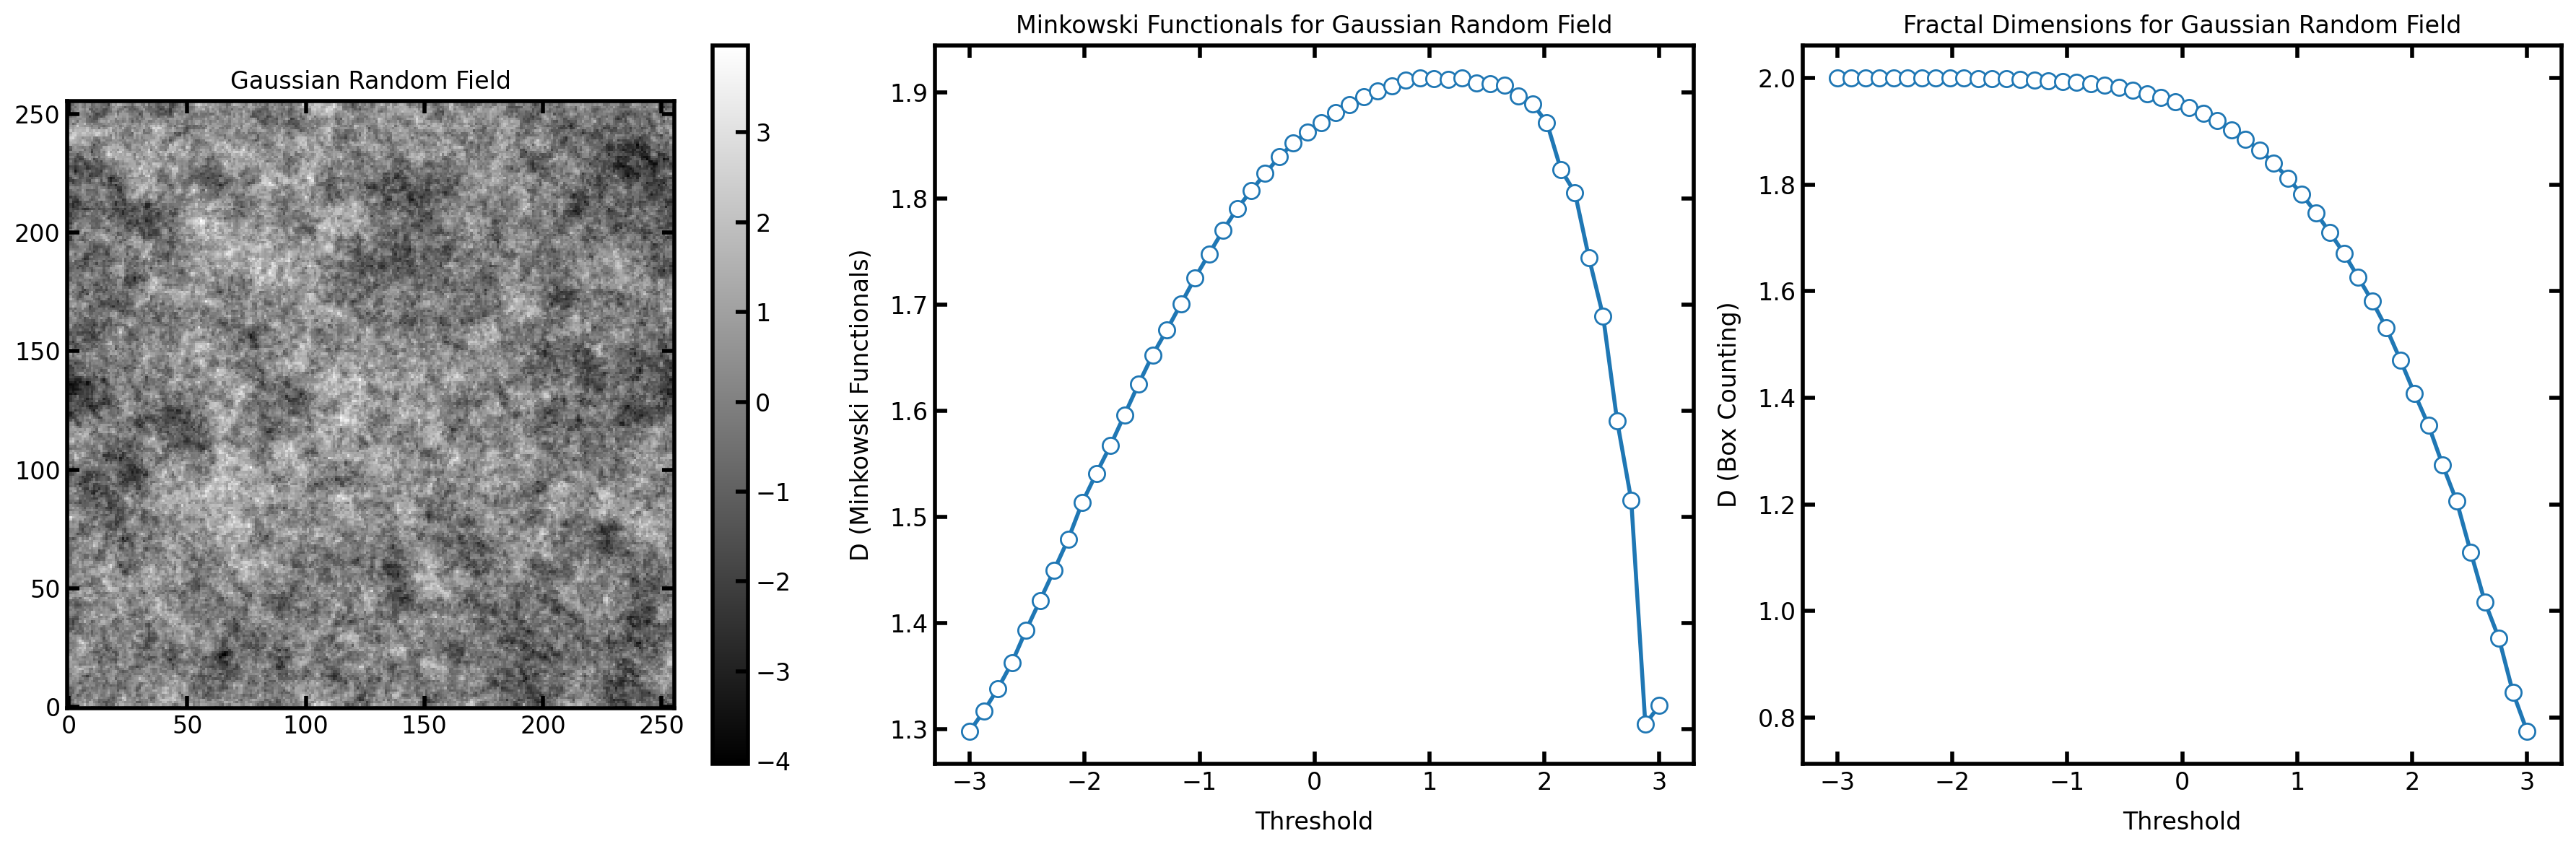

In [10]:
# Generate the Gaussian random field
size = 256   # Size of the grid (256x256)
a = -2.0     # Power spectrum exponent
field, field_CZ_eval = generate_gaussian_random_field(size, a)

# plot_GRF(field, field_CZ_eval, size)

# Calculate Minkowski functionals for the circle image
GRF_thresholds = np.linspace(-3., 3., 50)
GRF_results = standard_minkowski_functionals(field.astype(float), thresholds=GRF_thresholds)

# Calculate fractal dimensions using box counting method
GRF_fractal_dimensions_BC = []
for threshold in GRF_thresholds:
    GRF_fractal_dimensions_BC.append(box_counting(field >= threshold))

show_shapes_results(field, "Gaussian Random Field", GRF_thresholds, GRF_results, GRF_fractal_dimensions_BC)
# print(estimate_correlation_length(field, size))

### **6: Gaussian**

Here we also see some interesting facts about the Box Counting and the PA. The former behaves similarly to a GRF, precipiting to 0 after a while (this does not make a lot of sense to me). Instead, as we use the circle_corrected_minkowski_functional for the PA relation we retrieve a much more reliable result that deviates a bit (y axis differences are really small!) due to the not perfect circle nature of each threshold!

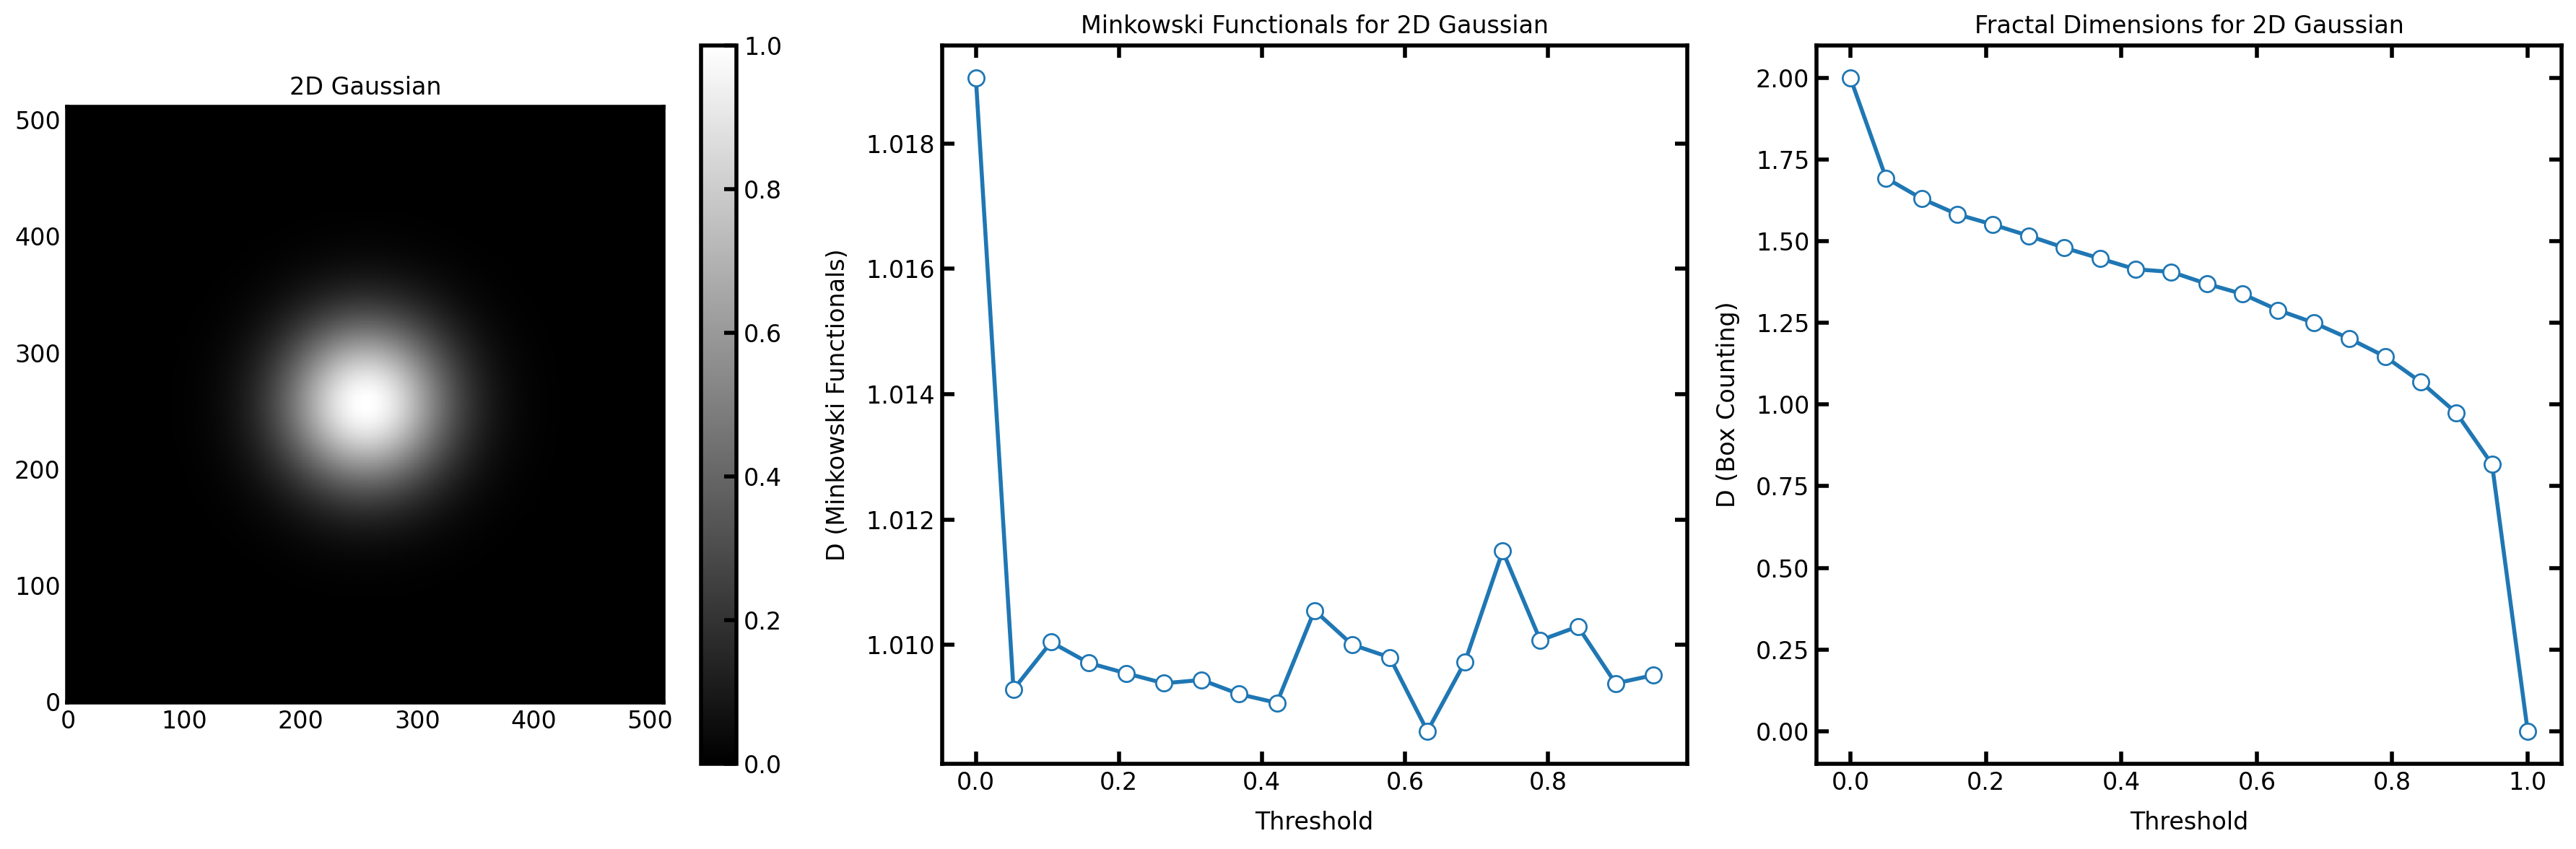

In [8]:
# Generate a single 2D Gaussian
shape = (512, 512)
center = (256, 256)  # Center of the Gaussian
sigma = 50  # Standard deviation of the Gaussian
gaussian = generate_2d_gaussian(shape, center, sigma)

# Calculate Minkowski functionals for the Gaussian
gaussian_thresholds = np.linspace(np.min(gaussian), np.max(gaussian), 20)
gaussian_results = circle_corrected_minkowski_functionals(gaussian, thresholds=gaussian_thresholds)

# Calculate fractal dimensions using box counting method
gaussian_fractal_dimensions_BC = []
for threshold in gaussian_thresholds:
    gaussian_fractal_dimensions_BC.append(box_counting(gaussian >= threshold))

show_shapes_results(gaussian, "2D Gaussian", gaussian_thresholds, gaussian_results, gaussian_fractal_dimensions_BC)

#### **Appendix A: Some of the attempts towards a General Formula accounting for the intercept**

In [ ]:
import numpy as np
from scipy.optimize import curve_fit

def minkowski_dimension_fit(areas, perimeters):
    """
    Fits the function P = k * A^(D/2) to estimate both D and k.
    
    Parameters:
        areas (array-like): List of area values.
        perimeters (array-like): Corresponding perimeter values.

    Returns:
        dict: Containing fitted values for D and k.
    """
    # Define the functional form P = k * A^(D/2)
    def model(A, D, k):
        return k*A**(D / 2)

    # Initial guess: D = 2 (Euclidean case), k = 1
    # Line
    initial_guess = [2, 1]
    
    # Plane
    initial_guess = [1, 3]

    # Circle
    initial_guess = [1, 3.5]
    
    # Fit the model
    params, _ = curve_fit(model, areas, perimeters, p0=initial_guess)

    # Extract fitted parameters
    D_fitted, k_fitted = params

    return {"D": D_fitted, "k": k_fitted}

def intercept_corrected_minkowski_functionals(data, threshold_min=1e20, threshold_max=1e22, thresholds=None):
    if thresholds is None:
        thresholds = np.logspace(np.log10(threshold_min), np.log10(threshold_max), 100)

    # Store Minkowski Functional values
    areas = []
    perimeters = []
    euler_chars = []

    # Process each threshold
    for threshold in thresholds:
        # Create binary mask
        mask = data >= threshold

        # Compute Area (v0)
        area = np.sum(mask)
        areas.append(area)

        # Compute Perimeter (v1) with correction for the intercept
        perim = perimeter(mask)
        perimeters.append(perim)

        # Compute Euler Characteristic (v2)
        euler_char = euler_number(mask)
        euler_chars.append(euler_char)

    # Convert to log scale for fractal dimension analysis
    log_areas = np.log10(areas)
    log_perimeters = np.log10(perimeters)

    fit = minkowski_dimension_fit(areas, perimeters)
    D = fit["D"]
    print(D)
    intercept = fit["k"]

    D = 2 * (log_perimeters - np.log10(fit["k"])) / (log_areas)
    # D = 2 * (log_perimeters) / (log_areas + np.log10(fit["k"]))

    return {
        "thresholds": thresholds,
        "values": [areas, perimeters, euler_chars, D],
        "intercept": intercept
    }

# Test on: line, plane, circle

# Line
line_results = intercept_corrected_minkowski_functionals(line_image.astype(float), thresholds=line_thresholds)

# Plane
plane_results = intercept_corrected_minkowski_functionals(box_image.astype(float), thresholds=box_thresholds)

# Circle
circle_results = intercept_corrected_minkowski_functionals(circle_image.astype(float), thresholds=circle_thresholds)

# Plot
plt.figure(figsize=(18, 6))

# Line
plt.subplot(1, 3, 1)
plt.plot(line_thresholds, line_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Intercept Corrected)')
plt.title(f'Intercept Corrected Minkowski Functionals for Line (Should be 2) \nIntercept: {line_results["intercept"]:.2f}')

# Plane
plt.subplot(1, 3, 2)
plt.plot(box_thresholds, plane_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Intercept Corrected)')
plt.title(f'Intercept Corrected Minkowski Functionals for Plane (Should be 1) \nIntercept: {plane_results["intercept"]:.2f}')

# Circle
plt.subplot(1, 3, 3)
plt.plot(circle_thresholds, circle_results["values"][3], "o-")
plt.xlabel('Threshold')
plt.ylabel('D (Intercept Corrected)')
plt.title(f'Intercept Corrected Minkowski Functionals for Circle (Should be 1) \nIntercept: {circle_results["intercept"]:.2f}')

plt.tight_layout()
plt.show()